# Final Project - Sensory Systems
Yoav Gur Arieh

In [1]:
# !pip install bidict pandas numpy matplotlib scikit-learn scikit-plot librosa

import re
import os
import os
import librosa
import IPython
import numpy as np
import pandas as pd
from tqdm import tqdm
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "./data/crcns/aa2/"

### The Research Question
The dataset I am working with is of single-unit recordings from different regions in the brains of birds while being played recordings of real bird songs as well as artificial ones. My research was about **how to programatically, based on the spiking data, predict whether the call played to the bird was a real or artificial one**.

The dataset - https://crcns.org/data-sets/aa/aa-2/about

### Theoretical Background
In the experiment the researchers play three types of calls to the birds: 
- Conspecific - Songs made by the birds of the same species.
- Flatrip - Modulation-Limited noise (ML-noise) with a flat modulation spectrum. This type of noise is meaningless sound with relatively uniform amplitude that is meant to mimic a song in terms of frequency range, spectral and temporal variations, and power.
- Songrip - Ripple stimuli mirroring the modulation spectrum of a song. These stimuli are meant to mimic the modulation patterns present in natural sounds like songs or speech, allowing researchers to analyze the neural response to more complex temporal patterns.

The researchers used extracellular electrophysiological recordings to determine the neurons' spiking behaviour.

In my research, I wanted to be able to classify whether the stimulus presented to the subject was real (conspecific) or artificial (flatrip, songrip) based on the subject's spiking data.

Sources:
- https://www.jneurosci.org/content/26/9/2499?utm_source=TrendMD&utm_medium=cpc&utm_campaign=JNeurosci_TrendMD_0
- https://pubs.aip.org/asa/jasa/article/134/2/EL217/950956/The-development-of-a-modified-spectral-ripple-test
- https://pubmed.ncbi.nlm.nih.gov/20554842/

Flatrip

In [3]:
IPython.display.Audio(os.path.join(DATA_PATH, "all_stims/1A556365C919DC0B02CF08D2D5CE4F7B.wav"))

Songrip

In [4]:
IPython.display.Audio(os.path.join(DATA_PATH, "all_stims/58C2739108AE5794D25F64CDDAF0F813.wav"))

Conspecific

In [5]:
IPython.display.Audio(os.path.join(DATA_PATH, "all_stims/D6E2826E7D682FFFD6DBB8E80B87DB22.wav"))

### Methods

**Models**

In our analysis of the data, we will use 3 classification techniques:
- Logistic Regression - a simple classification technique we can use for establishing a baseline for our models.
- K Nearest Neighbours - a classification technique that can be more useful if our dataset is more complex, nonlinear or noisy.
- Deep Neural Network - a technique that could allow us to capture even more complex relationships in our data, while incurring a higher computational cost.

My prediction is that the deep neural net will achieve the best results, then k nearest neighbours and lastly logistic regression.


**Data Structure**

In order to train our models on the data from the dataset, we need to structure the data in a normalized way for our model to learn from. Each experiment in the dataset consists of the spikes from cells in different regions in the brain as the bird is being exposed to a certain stimulus. The Stimuli are all under 4 seconds, and each spike is just a timestamp indicating that a cell had a spike at that time. The nature of the spike info is problematic for normalization since each cell could have a varying number of spikes during the stimulus, and at very different times. Therefore, to normalize the data for each experiment, I created a dataframe where each column (or feature) represents the spiking behaviour in a certain region of the brain, at a certain time. More specifically - for each brain region the experiment involves, I create 4000 columns, each of which represents whether that region had a cell spiking at that time (in ms). To differentiate between different cases, I made each feature entry contain a zero if there was no cell from that brain region in that experiment, and the amount of spikes in the time frame plus one otherwise (so if we had 5 different spikes from that region in a specific time the value will be 6).

The upsides of this method is that it's relatively simple, and contains all of the data we want our model to have. The downside is that the data we train the model on is now a lot bigger than it needs to be (e.g. if we have an experiment with a single spike in a single region, it'll still have a long row with a ton of zeros), making it less efficient than it could be. To sidestep this issue, I added a DIVISOR variable which I use for slotting together different timeslots into a single timeslot that will contain all of the spikes that occured within that slot. This makes it so instead of 4000 features per brain region we have 4000/DIVISOR features per brain region. From my experimenting I found that 70 provides a good balance between efficiency and accuracy.

**Evaluation**

When evaluating the models I used the techniques we learned in class - using a confusion matrix to assess the model's lean, as well as a ROC curve to assess it according to its specificity and sensitivity.

I also wanted to gain insight into which features were most important for the model to make its predictions. I used separate techniques when doing so for logistic regression and deep neural networks:
- Logistic Regression - we look at the coefficients associated with each feature, with the magnitude of the coefficient indicating the strength of its relationship to the prediction of the model.
- Deep Neural Network - since we have multiple layers of weights, it's not trivial to use the previous method to assess feature importance. Instead we go feature by feature, insert random noise, and see how that affects the model's accuracy. The higher the impact, the more important the feature is.

These methods aren't perfect, but can give a good estimation regarding feature importance, and can give us more insight into how our model works, as well as into what separates the stimuli classes apart.

### Analysis

The structure of the dataset is outlined [here](https://crcns.org/files/data/aa-2/crcns-aa2-README.txt). To start working with it we first go over the all relevant files and cross reference them to get a single dataframe with all of the information we need to start working. The dataframe contains a row for each experiment and contains the following fields:
- cell_id
- trial_index - the index of the experiment run
- group_index - the index shared by units which were recorded simultaneously in experiments
- bird - the id of the bird
- nb_trials
- brain_region
- stimulus_type (conspecific, songrip, flatrip)
- stimulus_file
- spike_file

In [6]:
stims_path = os.path.join(DATA_PATH, "all_stims")
cells_path = os.path.join(DATA_PATH, "all_cells")

brain_area_mapping = {
    'OV': 'Nucleus Ovoidalis',
    'L3': 'Downstream Auditory Pallial Region (L3)',
    'mld': 'Mesencephalicus Lateralis Dorsalis',
    'CM': 'Caudal Mesopallium',
    'None': 'None',
    'L2a': 'Downstream Auditory Pallial Region (L2a)',
    'L': 'Downstream Auditory Pallial Region (L)',
    'L1': 'Downstream Auditory Pallial Region (L1)',
    'L2b': 'Downstream Auditory Pallial Region (L2b)',
}

def listdir(path):
    return [x for x in os.listdir(path) if not x.startswith(".")]

def get_region(regions_df, cell_id):
    regions = regions_df[regions_df.index == cell_id]["region"].values
    assert len(regions) == 1, f"Unexpected number of regions: {len(regions)}"
    return brain_area_mapping[regions[0]]

def get_main_df():
    d = {"bird": [], "cell_id": [], "group_index": [], "trial_index": [], "nb_trials": [], "brain_region": [], "stimulus_type": [], "stimulus_file": [], "spike_file": []}

    cell_regions_df = pd.read_csv(os.path.join(DATA_PATH, "cell_regions.csv"), header=None, index_col=0)
    cell_regions_df.columns = ["region"]
    cell_regions_df.index.name = "Cell ID"

    cells = listdir(cells_path)
    for cell in cells:
        stim_types = listdir(os.path.join(cells_path, cell))
        for stim_type in stim_types:
            cell_stimuli_paths = []
            spike_paths = []

            stim_files = listdir(os.path.join(cells_path, cell, stim_type))
            for stim_file in stim_files:
                if stim_file.startswith("spike"):
                    spike_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                elif stim_file.startswith("stim"):
                    cell_stimuli_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                else:
                    assert False, f"Unexpected file prefix: {stim_file}"

            spike_paths.sort()
            cell_stimuli_paths.sort()

            for spike_path, stim_path in zip(spike_paths, cell_stimuli_paths):
                stim_index = int(re.findall(r"\d+", stim_path)[-1])
                spike_index = int(re.findall(r"\d+", spike_path)[-1])

                if spike_index != stim_index:
                    continue

                with open(stim_path, "r") as f:
                    stim_file_path = os.path.join(stims_path, f.read().strip())

                with open(spike_path, "r") as f:
                    spike_trials = f.read().splitlines()

                bird, cell_id = cell.split("_", 1)
                if "_" in cell_id:
                    cell_id, group_index = cell_id.split("_")
                else:
                    group_index = 'A'

                d["cell_id"].append(cell_id)
                d["trial_index"].append(stim_index)
                d["group_index"].append(group_index)
                d["bird"].append(bird)
                d["nb_trials"].append(len(spike_trials))
                d["brain_region"].append(get_region(cell_regions_df, cell))
                d["stimulus_type"].append(stim_type)
                d["stimulus_file"].append(stim_file_path)
                d["spike_file"].append(spike_path)

    df = pd.DataFrame(d)
    return df[df.brain_region != "None"]

In [7]:
df = get_main_df()
df

,bird,cell_id,group_index,trial_index,nb_trials,brain_region,stimulus_type,stimulus_file,spike_file
0,gr0869,5,A,1,14,Nucleus Ovoidalis,flatrip,./data/crcns/aa2/all_stims/1A556365C919DC0B02C...,./data/crcns/aa2/all_cells/gr0869_5/flatrip/sp...
1,gr0869,5,A,10,14,Nucleus Ovoidalis,flatrip,./data/crcns/aa2/all_stims/C220747BA5622568C5E...,./data/crcns/aa2/all_cells/gr0869_5/flatrip/sp...
2,gr0869,5,A,2,14,Nucleus Ovoidalis,flatrip,./data/crcns/aa2/all_stims/A972CD10BAE3A93D8BC...,./data/crcns/aa2/all_cells/gr0869_5/flatrip/sp...
3,gr0869,5,A,3,14,Nucleus Ovoidalis,flatrip,./data/crcns/aa2/all_stims/9E6F33894372F03408F...,./data/crcns/aa2/all_cells/gr0869_5/flatrip/sp...
4,gr0869,5,A,4,14,Nucleus Ovoidalis,flatrip,./data/crcns/aa2/all_stims/6291D00257F5DEE3D64...,./data/crcns/aa2/all_cells/gr0869_5/flatrip/sp...
...,...,...,...,...,...,...,...,...,...
18964,publu0717,4,A,5,10,Mesencephalicus Lateralis Dorsalis,conspecific,./data/crcns/aa2/all_stims/0A07B255BF830083B67...,./data/crcns/aa2/all_cells/publu0717_4_A/consp...
18965,publu0717,4,A,6,10,Mesencephalicus Lateralis Dorsalis,conspecific,./data/crcns/aa2/all_stims/DB500570216F0412EE8...,./data/crcns/aa2/all_cells/publu0717_4_A/consp...
18966,publu0717,4,A,7,10,Mesencephalicus Lateralis Dorsalis,conspecific,./data/crcns/aa2/all_stims/4922458336F516A1D0E...,./data/crcns/aa2/all_cells/publu0717_4_A/consp...
18967,publu0717,4,A,8,10,Mesencephalicus Lateralis Dorsalis,conspecific,./data/crcns/aa2/all_stims/1470489635DD9341040...,./data/crcns/aa2/all_cells/publu0717_4_A/consp...


We can see that the number of appearances of each class is more or less equal, which is important since if there was a major imbalance it would affect our models.

In [8]:
df.stimulus_type.apply(lambda x: "real" if x == "conspecific" else "artificial").value_counts()

artificial    8412
real          8309
Name: stimulus_type, dtype: int64

As explained in the methods section, the matrix my models will use for training and infering will have a row for each brain region and time section. The best grouping divisor in terms of maximizing accuracy and speed I found was 70, and so in this cell we use that divisor and go over all spike times in the dataset to find the max time so we know how to build our dataframe.

In [9]:
DIVISOR = 70

max_times = []
for i in range(len(df)):
    with open(df.iloc[i].spike_file, "r") as features:
        max_times.append(max([float(y) for x in features.read().split('\n') for y in x.split()]))

max_time = int((max(max_times)) / DIVISOR) + 1

In this cell I validate certain aspects of the data and throw out data that doesn't make sense. Namely, I make sure that each trial has the same stimulus type and number of trials across all cells included in the trial. There is a small number of trials that seem to be somewhat malformed, and so we just remove them from the dataset (the readme and paper which discuss this dataset don't explain the format of the dataset much, so there's not much else we can do).

In [10]:
groups = list(df.groupby(["bird", "group_index", "trial_index", "stimulus_type"]))
probs = []

for group, gdf in groups:
    try:
        assert gdf.stimulus_type.nunique() == 1
        assert gdf.nb_trials.nunique() == 1
    except:
       probs.append(group) 

for bird, group_index, trial_index, stimulus_type in probs:
    df = df[(df.bird != bird) | (df.group_index != group_index) | (df.trial_index != trial_index) | (df.stimulus_type != stimulus_type)]

These bidicts are useful bidirectional mappings between our data and embeddings.

In [11]:
cell_ids = bidict({cell_id: i for i, cell_id in enumerate(set(df.index))})
brain_regions = bidict({region: i for i, region in enumerate(set(df.brain_region))})
stimulus_types = bidict({stimulus: i for i, stimulus in enumerate(set(df.stimulus_type))})

Now we build the dataset that we'll use with our models. We do this by going over each experiment (df.groupby) and reading all of the matching spikes together from each spikes file, then put all of the data in the dataframe as outlined in the methods section.

In [12]:
d = {f"{y}_{x}": [] for y in brain_regions for x in range(max_time)}
y = []

for (bird, group_index, trial_index, stimulus_type), group in tqdm(df.groupby(["bird", "group_index", "trial_index", "stimulus_type"])):
    nb_trials = group.iloc[0].nb_trials

    files = []
    for path, region in zip(group.spike_file, group.brain_region):
        files.append((open(path, "r"), region))

    for x in range(nb_trials):
        spikes = defaultdict(int)
        for features, region in files:
            for spike in features.readline().split():
                spike = int(float(spike) / DIVISOR)

                if spike >= 0 and spike <= max_time:
                    spikes[f"{region}_{spike}"] += 1
                
        for time in range(max_time):
            regions = set(group.brain_region.values)
            for region in brain_regions:
                if region in regions:
                    d[f"{region}_{time}"].append(spikes[f"{region}_{time}"] + 1)
                else:
                    d[f"{region}_{time}"].append(0)

        y.append(1 if stimulus_type == "conspecific" else 0)

    for file, _ in files:
        file.close()
        
X = pd.DataFrame(d)

  0%|          | 0/3823 [00:00<?, ?it/s]

100%|██████████| 3823/3823 [00:12<00:00, 309.50it/s]


Separate the data into train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We'll use these functions to evaluate each model we use.

In [14]:
# Plot a confusion matrix as well as a ROC curve for a given model to evaluate its performance
def evaluate_model(model):
    _, axes = plt.subplots(1, 2, figsize=(15, 5))

    print("Model accuracy: ", round(model.score(X_test,y_test), 4))
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artificial", "Conspecific"])
    disp.plot(ax=axes[0])

    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    axes[0].set_title(f"Confusion Matrix ({model.__class__.__name__})")

    axes[1].plot(fpr,tpr,label=f"auc={round(auc, 4)}")
    axes[1].plot([0, 1], [0, 1],'--', color="gray", alpha=0.5)
    axes[1].legend(loc=4)
    axes[1].set_title(f"ROC Curve ({model.__class__.__name__})")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")

    plt.show()

# Plot the feature importances for a given model. This will plot the top 30 features by importance, as well as the importance of each feature over time and by region.
def plot_feature_importances(model, features):
    _, ax = plt.subplots(figsize=(16, 6))
    _, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes = axes.flatten()

    features = features.sort_values('Importance', ascending=True)
    features.tail(30).plot(x='Feature', y='Importance', kind='barh', ax=ax, legend=False, xlabel="Importance", title="Top 30 Features by Importance")

    time_features = features.copy()
    time_features.Feature = time_features.Feature.apply(lambda x: (int(x.split("_", 1)[1]) * DIVISOR) / 1000)

    group = time_features.groupby('Feature').sum().sort_values('Importance', ascending=True)
    group = group.sort_index()
    axes[1].plot(group.index, group.Importance)
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Importance")
    axes[1].set_title("Importance by Time")

    region_features = features.copy()
    region_features.Feature = region_features.Feature.apply(lambda x: x.split("_", 1)[0])
    region_features.groupby('Feature').sum().sort_values('Importance', ascending=True).plot(kind='barh', ax=axes[0], legend=False, xlabel="Importance", ylabel="Region", title="Importance by Region")


    plt.show()

As described in the methods section, we'll start by seeing whether a simple logistic regression classifier will work. This method is a relatively fast and efficient way of classifying between the two categories, and can serve as a good baseline. We can see that we got a pretty high accuracy rate of 0.79, with a ROC-AUC of 0.87, which is a really great start.

Model accuracy:  0.7932


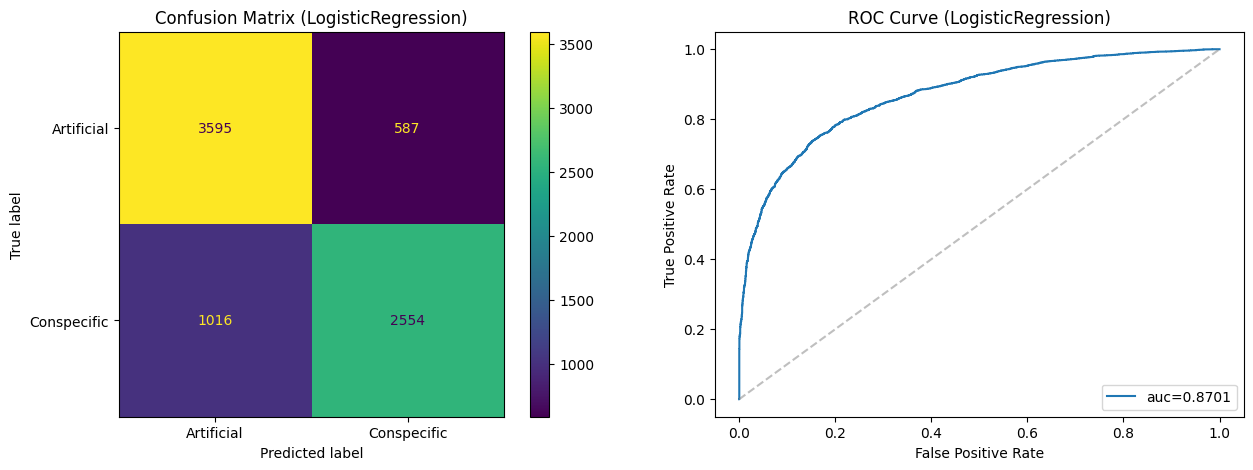

In [15]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train, y_train)
evaluate_model(LR)

We can now perform some simple analysis of the model to assess the different features' importances, which can allow us to know which times are most crucial for differentiation, as well as which regions. We do this by constructing an importances dataframe from the coef_ member of our classifier, and extracting the relevant data from it.

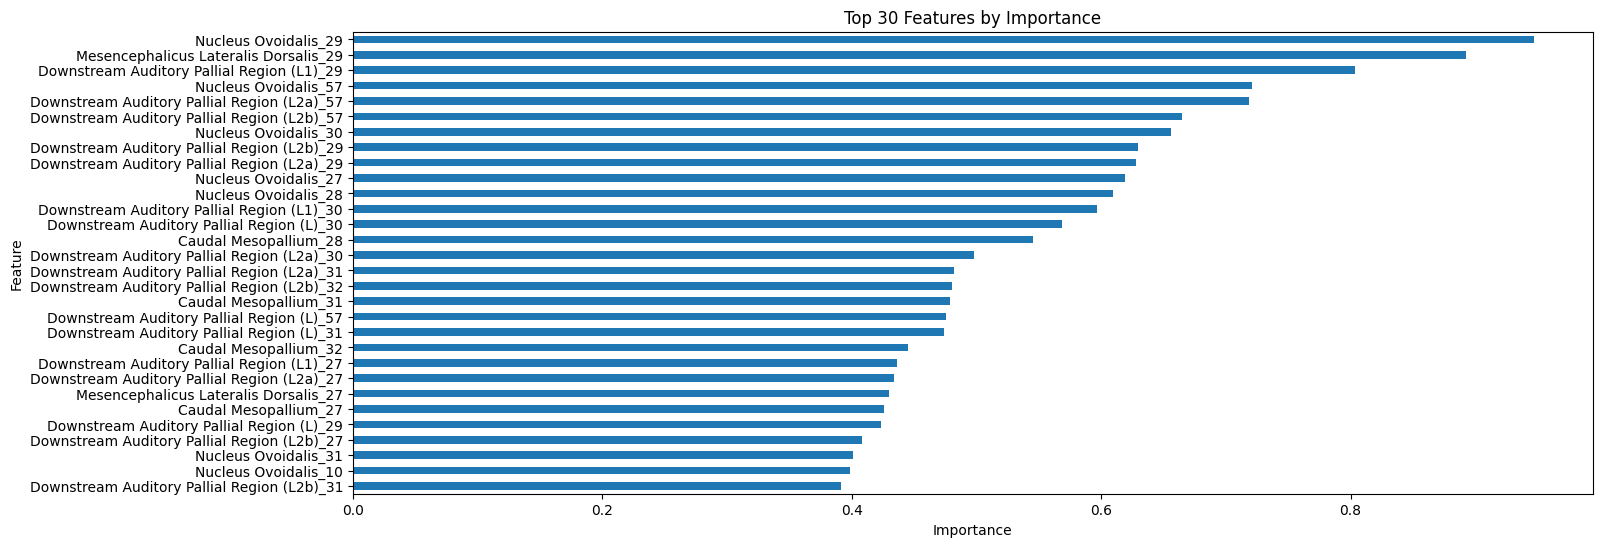

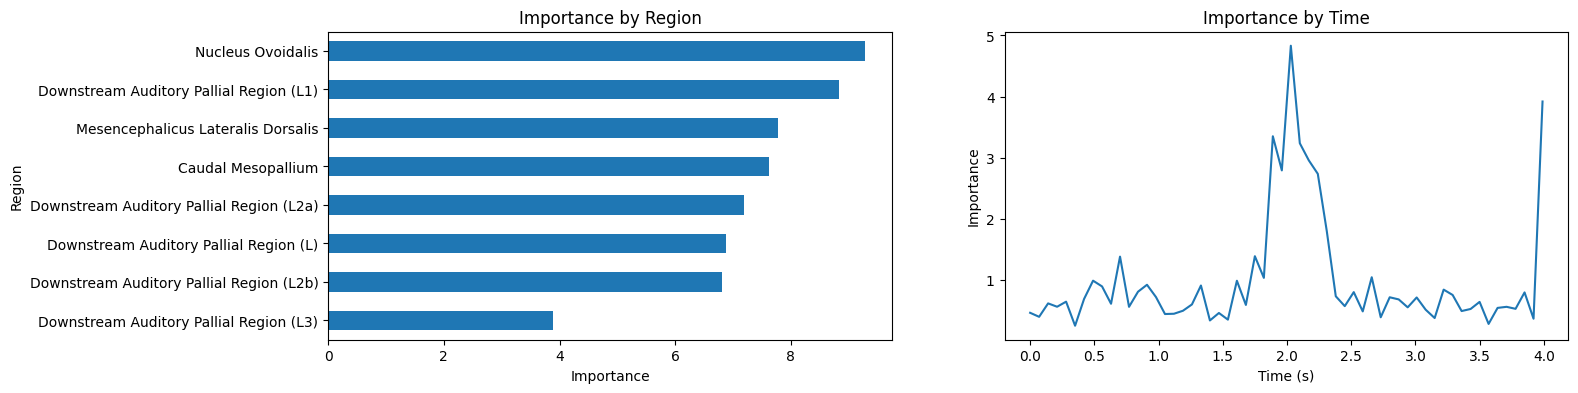

In [16]:
plot_feature_importances(LR, pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(LR.coef_[0])}))

We can now attempt to use K Nearest Neighbours to classify our data. This method could be more accurate when dealing with complex or non-linear relationships between the features and the target. We can see that this did indeed increase our accuracy and ROC-AUC to 0.83 and 0.91 respectively.

Model accuracy:  0.8297


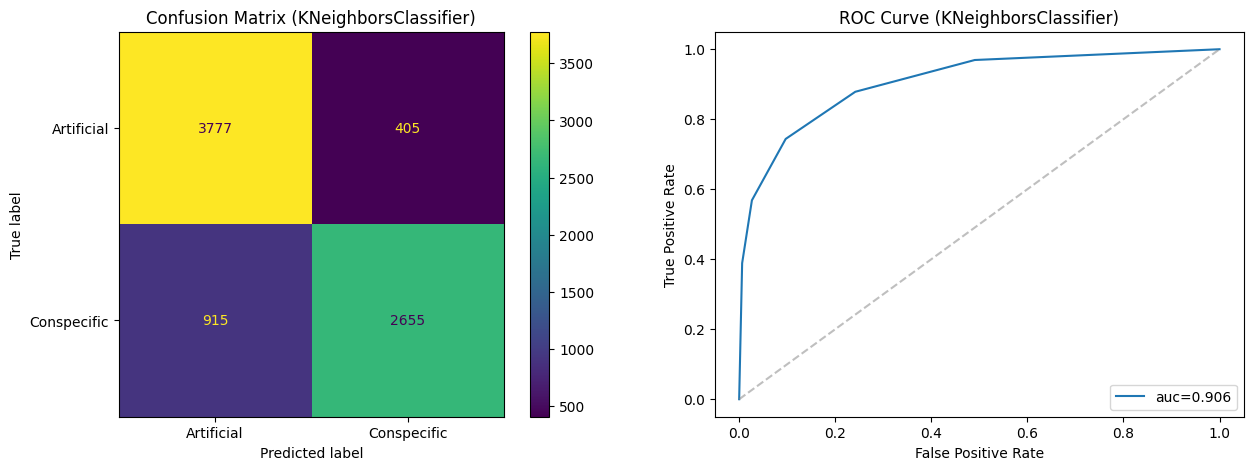

In [17]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train) 
evaluate_model(KNN)

Lastly, we can use a deep neural network to perform the classification. To achieve this we define a classifier with 3 hidden layers, using sizes that make for a good tradeoff between accuracy and time taken to train. We can see that this model performs the best out of all three, with an accuracy and ROC-AUC of 0.86 and 0.94 respectively.

Model accuracy:  0.8643


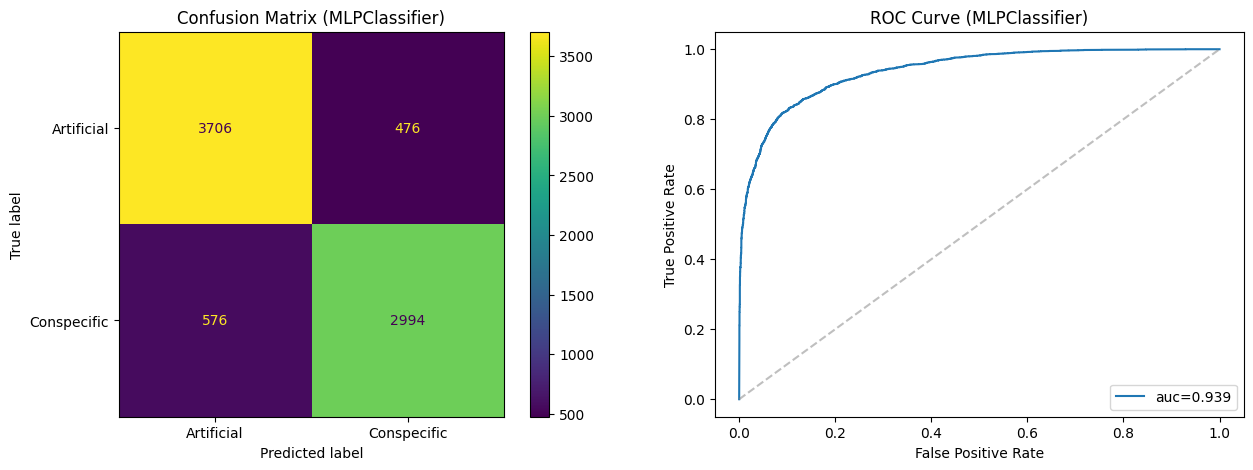

In [18]:
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(300, 200, 100), random_state=1).fit(X_train, y_train)
evaluate_model(NN)

This time, to get the feature importances we permutate each column of features and calculate the accuracy difference after doing so. The higher the difference the more important the feature is.

  0%|          | 0/464 [00:00<?, ?it/s]

100%|██████████| 464/464 [02:33<00:00,  3.03it/s]


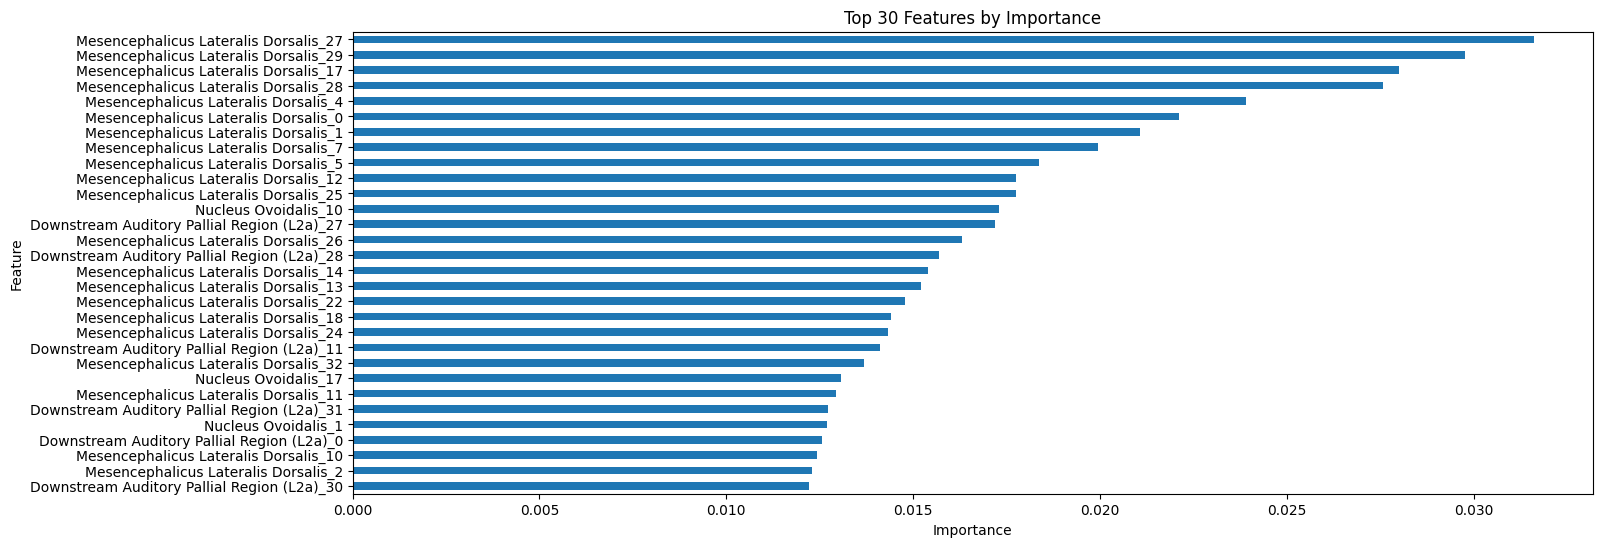

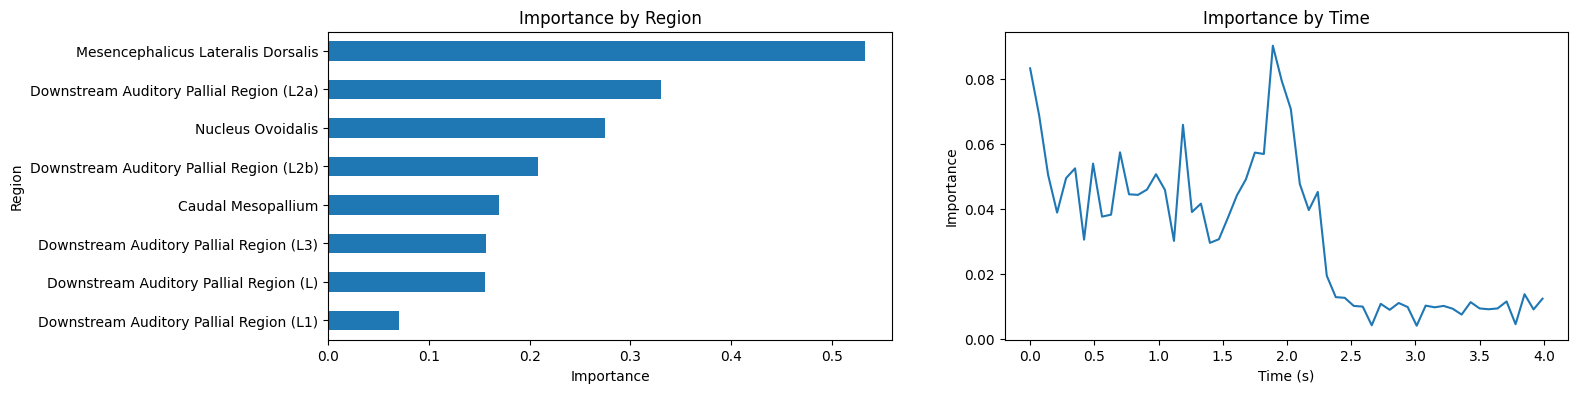

In [19]:
def get_feature_importance(feature_index, nb_trials):
  s = accuracy_score(y_test, NN.predict(X_test_np)) # baseline score

  total = 0.0
  for _ in range(nb_trials):
    perm = np.random.permutation(range(X_test_np.shape[0]))
    X_test_ = X_test_np.copy()
    X_test_[:, feature_index] = X_test_np[perm, feature_index]

    y_pred_ = NN.predict(X_test_)
    s_ij = accuracy_score(y_test, y_pred_)
    total += s_ij

  return s - total / nb_trials

features = []
X_test_np = X_test.to_numpy()
for j in tqdm(range(X_test_np.shape[1])):
  features_j = get_feature_importance(j, 3)
  features.append(features_j)

plot_feature_importances(NN, pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(features)}))

### Summary

**Evaluating The Models**

As predicted, the deep neural net achieved the best results, with an accuracy of 0.86 and a ROC-AUC of 0.94. Interestingly, the logistic regression model performed almost as well, with an accuracy of 0.79 and ROC-AUC of 0.87, while running in just a few seconds as opposed to a number of minutes. The KNN also did indeed have better performance than the logistic regression model, with an accuracy of 0.83 and ROC-AUC of 0.91, while only taking slightly longer to run. The neural net ran for the longest by far, but did achieve the best results.

**Feature Importances**

Both feature importance analyses provide interesting insights into the models' inner workings, and their assessment of the most important features. Both models give the most weight to the spikes occurring between 1.5 and 2.5 seconds after stimulus start, while the neural net gives more weight to the beginning of the track than the end of it. Both also give a lot of weight to spikes occurring in the Mesencephalicus Lateralis Dorsalis and Nucleus Ovoidalis regions, but do differ for example in how much weight they give the Downstream Auditory Pallial Region (L1) region (with the neural network giving it the least weight, and the logistic regression model giving it nearly the most weight).

**Limitations**

Towards the end of my research, I realized that there could exist a potential issue with the dataset if the stimulus lengths were unequal between the different categories. After checking I found that this issue does exist, with all artificial stimuli being exactly 2 seconds long, and the real stimuli being between 0.1 and 2.5 seconds long. This poses a big problem in terms of the validity of our model since it might be 'cheating' by for example deducing a stimulus is real if it has spikes after the 2 second mark. This isn't exactly the case since spikes can occur a while after the end of the stimuli, and because much of the real stimuli are also shorter than 2 seconds. It also raises the question of whether the increased weight given to spikes at between 1.5 and 2.5 seconds is related to this.

A possible solution to this issue would be cull any real stimuli that are much longer or shorter than 2 seconds, but the problem is somewhat inherent to the dataset, and the real solution would be to perform the experiments again but with variable lengths for the artificial stimuli that distribute similarly to the real stimuli.

**Summary**

Using all three models we achieved very high accuracy and ROC-AUC scores, allowing us to programatically classify between the different stimulus types based on the birds' neuronal spiking behaviour, as we set out to do in our research.
